Epoch:0/200 Error_train: 0.5840150844962249 Error_test: 0.5824264812031869


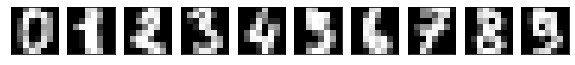

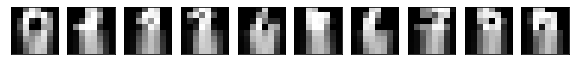

Epoch:10/200 Error_train: 0.4168113998790675 Error_test: 0.4184521309248046


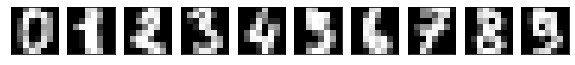

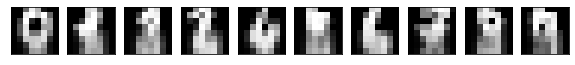

Epoch:20/200 Error_train: 0.3690042274807415 Error_test: 0.3738585333701286


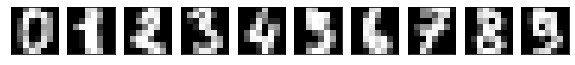

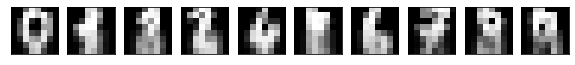

Epoch:30/200 Error_train: 0.3250867592175828 Error_test: 0.3382541629979638


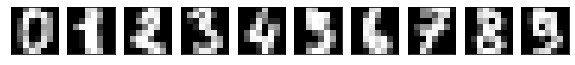

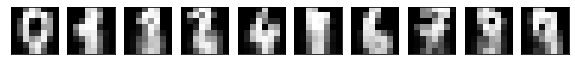

Epoch:40/200 Error_train: 0.3008070173394656 Error_test: 0.31961529215045764


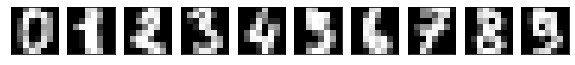

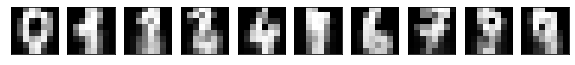

Epoch:50/200 Error_train: 0.29142884533268837 Error_test: 0.3138470082230166


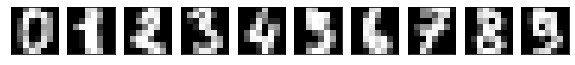

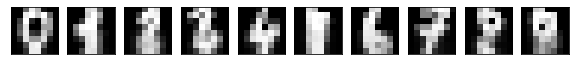

Epoch:60/200 Error_train: 0.2864058577859601 Error_test: 0.3170323893101197


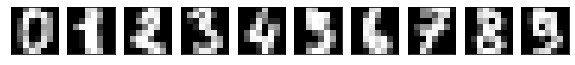

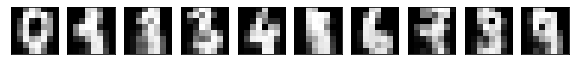

Epoch:70/200 Error_train: 0.2544434027925505 Error_test: 0.28827349188337903


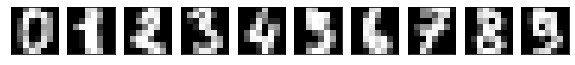

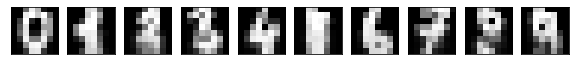

Epoch:80/200 Error_train: 0.25102371590698014 Error_test: 0.29015745420472744


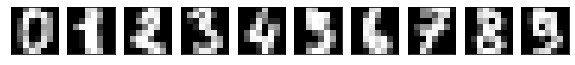

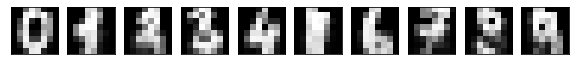

Epoch:90/200 Error_train: 0.2328430047912898 Error_test: 0.2744638918173372


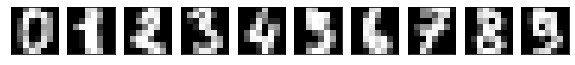

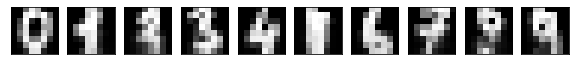

Epoch:100/200 Error_train: 0.22719480747409038 Error_test: 0.2710281406122153


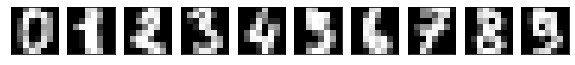

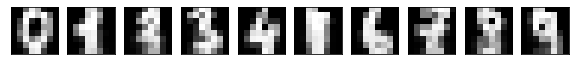

Epoch:110/200 Error_train: 0.21733603460162568 Error_test: 0.2657086368180914


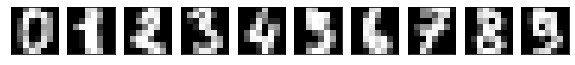

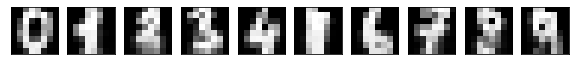

Epoch:120/200 Error_train: 0.21146245756504461 Error_test: 0.2640532398290229


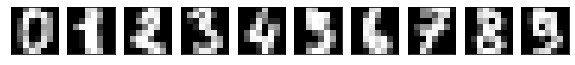

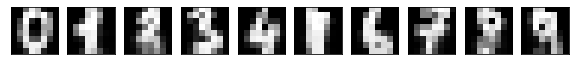

Epoch:130/200 Error_train: 0.21570834274222708 Error_test: 0.27506857837772064


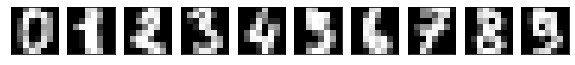

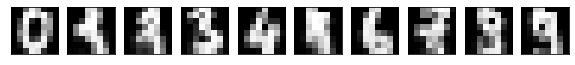

Epoch:140/200 Error_train: 0.1934035573373173 Error_test: 0.253795966990007


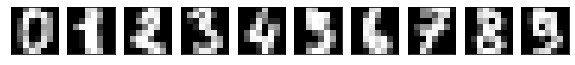

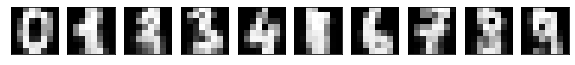

Epoch:150/200 Error_train: 0.18879448297907442 Error_test: 0.25251677555280294


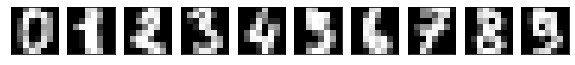

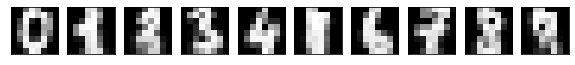

Epoch:160/200 Error_train: 0.18709275748281837 Error_test: 0.25580307142159364


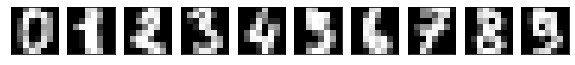

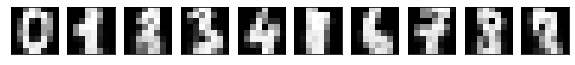

Epoch:170/200 Error_train: 0.186374903436447 Error_test: 0.2584518410799553


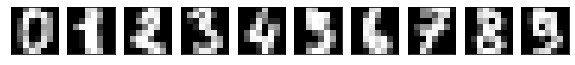

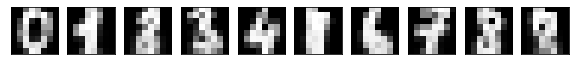

Epoch:180/200 Error_train: 0.1800414881138698 Error_test: 0.25232757009768875


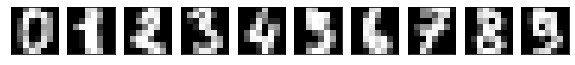

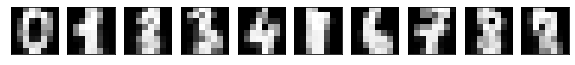

Epoch:190/200 Error_train: 0.16796726705714582 Error_test: 0.24853112227494786


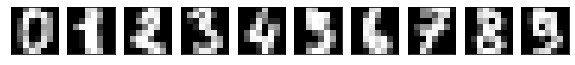

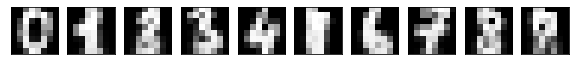

Epoch:200/200 Error_train: 0.16472765855416557 Error_test: 0.2503921740827968


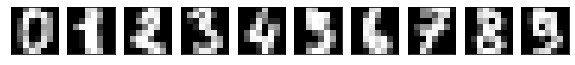

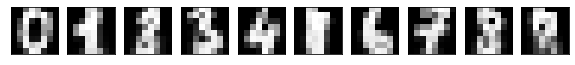

In [15]:
# import numpy as np
import cupy as np
import matplotlib.pyplot as plt
from sklearn import datasets
from sklearn.model_selection import train_test_split

# -- 각 설정값 --
img_size = 8       # 이미지의 높이와 폭
n_time = 4         # 시계열 데이터의 개수
n_in = img_size    # 입력층의 뉴런 수
n_mid = 128        # 은닉층의 뉴런 수
n_out = img_size   # 출력층의 뉴런 수
n_disp = 10        # 표시할 이미지 개수

eta = 0.01         # 학습률
epochs = 201
batch_size = 32
interval = 10      # 학습 결과 표시 간격

def sigmoid(x):
    return 1/(1+np.exp(-x))

# -- 이미지 데이터 준비 --
digits = datasets.load_digits()
digits = np.asarray(digits.data)
digits_imgs = digits.reshape(-1, img_size, img_size)
digits_imgs /= 15

disp_imgs = digits_imgs[:n_disp]              # 결과를 나타냄
train_imgs = digits_imgs[n_disp:]             # 훈련
n_sample_in_img = img_size-n_time             # 이미지 하나 안 샘플 수
n_sample = len(train_imgs) * n_sample_in_img  # 샘플 수

input_data = np.zeros((n_sample, n_time, n_in))  # 입력
correct_data = np.zeros((n_sample, n_out))       # 정답
for i in range(len(train_imgs)):
    for j in range(n_sample_in_img):
        sample_id = i*n_sample_in_img + j
        input_data[sample_id] = train_imgs[i, j:j+n_time]
        correct_data[sample_id] = train_imgs[i, j+n_time]

x_train, x_test, t_train, t_test = train_test_split(input_data, correct_data)

# -- GRU층 --
class GRULayer:
    def __init__(self, n_upper, n):
        # 파라미터의 초깃값
        self.w = np.random.randn(3, n_upper, n) / np.sqrt(n_upper)
        self.v = np.random.randn(3, n, n) / np.sqrt(n)
        
    def forward(self, x, y_prev):
        a0 = sigmoid(np.dot(x, self.w[0]) + np.dot(y_prev, self.v[0]))     # 업데이트 게이트
        a1 = sigmoid(np.dot(x, self.w[1]) + np.dot(y_prev, self.v[1]))     # 재설정 게이트
        a2 = np.tanh(np.dot(x, self.w[2]) + np.dot(a1*y_prev, self.v[2]))  # 새로운 기억
        self.gates = np.stack((a0, a1, a2))
        
        self.y = (1-a0)*y_prev + a0*a2     # 출력
        
    def backward(self, x, y, y_prev, gates, grad_y):
        a0, a1, a2 = gates
        
        # 새로운 기억
        delta_a2 = grad_y * a0 * (1-a2**2)
        self.grad_w[2] += np.dot(x.T, delta_a2)
        self.grad_v[2] += np.dot((a1*y_prev).T, delta_a2)
        
        # 업데이트 게이트
        delta_a0 = grad_y * (a2-y_prev) * a0 * (1-a0)
        self.grad_w[0] += np.dot(x.T, delta_a0)
        self.grad_v[0] += np.dot(y_prev.T, delta_a0)
        
        # 리셋 게이트
        s = np.dot(delta_a2, self.v[2].T)
        delta_a1 = s * y_prev * a1 * (1-a1)
        self.grad_w[1] += np.dot(x.T, delta_a1)
        self.grad_v[1] += np.dot(y_prev.T, delta_a1)
        
        # x의 기울기
        self.grad_x = np.dot(delta_a0, self.w[0].T) 
        + np.dot(delta_a1, self.w[1].T) 
        + np.dot(delta_a2, self.w[2].T)
        
        # y_prev 기울기
        self.grad_y_prev = np.dot(delta_a0, self.v[0].T)
        + np.dot(delta_a1, self.v[1].T)
        + a1*s + grad_y*(1-a0)
        
    def reset_sum_grad(self):
        self.grad_w = np.zeros_like(self.w)
        self.grad_v = np.zeros_like(self.v)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.v -= eta * self.grad_v
        
# -- 전결합 출력층 --
class OutputLayer:
    def __init__(self, n_upper, n):
        # 자비에르 초기화(Xavier Initialization) 기반의 초깃값
        self.w = np.random.randn(n_upper, n) / np.sqrt(n_upper)
        self.b = np.zeros(n)
        
    def forward(self, x):
        self.x = x
        u = np.dot(x, self.w) + self.b
        self.y = 1/(1+np.exp(-u))      # 시그모이드 함수
        
    def backward(self, t):
        delta = (self.y - t) * self.y * (1-self.y)
        
        self.grad_w = np.dot(self.x.T, delta)
        self.grad_b = np.sum(delta, axis=0)
        self.grad_x = np.dot(delta, self.w.T)
        
    def update(self, eta):
        self.w -= eta * self.grad_w
        self.b -= eta * self.grad_b
        
# -- 각 신경망층의 초기화 --
gru_layer = GRULayer(n_in, n_mid)
output_layer = OutputLayer(n_mid, n_out)

# -- 훈련 --
def train(x_mb, t_mb):
    # 순전파 GRU층
    y_rnn = np.zeros((len(x_mb), n_time+1, n_mid))
    gates_rnn = np.zeros((3, len(x_mb), n_time, n_mid))
    y_prev = y_rnn[:, 0, :]
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        
        y = gru_layer.y
        y_rnn[:, i+1, :] = y
        y_prev = y
        
        gates = gru_layer.gates
        gates_rnn[:,:,i,:] = gates
        
    # 순전파 출력층
    output_layer.forward(y)
    
    # 역전파 출력층
    output_layer.backward(t_mb)
    grad_y = output_layer.grad_x
    
    # 역전파 GRU층
    gru_layer.reset_sum_grad()
    for i in reversed(range(n_time)):
        x = x_mb[:, i, :]
        y = y_rnn[:,i+1,:]
        y_prev = y_rnn[:, i, :]
        gates = gates_rnn[:,:,i,:]
        
        gru_layer.backward(x, y, y_prev, gates, grad_y)
        grad_y = gru_layer.grad_y_prev
        
    # 파라미터 갱신
    gru_layer.update(eta)
    output_layer.update(eta)
    
# -- 예측 --
def predict(x_mb):
    # 순전파 GRU층
    y_prev = np.zeros((len(x_mb), n_mid))
    for i in range(n_time):
        x = x_mb[:, i, :]
        gru_layer.forward(x, y_prev)
        y = gru_layer.y
        y_prev = y
        
    # 순전파 출력층
    output_layer.forward(y)
    return output_layer.y

# -- 오차 계산 --
def get_error(x, t):
    y = predict(x)
    return np.sum(np.square(y - t)) / len(x)   # 오차 제곱의 합

# -- 이미지를 생성하고 나타냄 --
def generate_images():
    # 원본 이미지
    plt.figure(figsize=(10,1))
    for i in range(n_disp):
        ax = plt.subplot(1, n_disp, i+1)
#         print("원본")
#         print(disp_imgs[i])
        plt.imshow(disp_imgs[i].tolist(), cmap="Greys_r")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
    # 아래쪽 절반 부분을 RNN으로 생성한 이미지
    gen_imgs = disp_imgs.copy()
    plt.figure(figsize=(10, 1))
    for i in range(n_disp):
        for j in range(n_sample_in_img):
            x = gen_imgs[i, j:j+n_time].reshape(1, n_time, img_size)
            gen_imgs[i, j+n_time] = predict(x)[0]
        ax = plt.subplot(1, n_disp, i+1)
#         print("생성")
#         print(gen_imgs[i])
        plt.imshow(gen_imgs[i].tolist(), cmap="Greys_r")
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
    plt.show()
    
n_batch = len(x_train) // batch_size     # 1에포크당 배치 개수

for i in range(epochs):
    # -- 학습 --
    index_random = np.arange(len(x_train))
    np.random.shuffle(index_random)      # 인덱스 뒤섞기(셔플하기)
    for j in range(n_batch):
        # 미니 배치 학습 실행
        mb_index = index_random[j*batch_size : (j+1)*batch_size]
        x_mb = x_train[mb_index, :]
        t_mb = t_train[mb_index, :]
        
        # 훈련
        train(x_mb, t_mb)
        
    # -- 결과 확인 --
    if i%interval == 0:
        # 오차 측정
        error_train = get_error(x_train, t_train)
        error_test = get_error(x_test, t_test)
        print("Epoch:" + str(i) + "/" + str(epochs-1),
              "Error_train: " + str(error_train),
              "Error_test: " + str(error_test))
        
        # 이미지 생성
        generate_images()